## Part 1 - Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
login = pd.read_json('logins.json')

In [3]:
login.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
login.dtypes

login_time    datetime64[ns]
dtype: object

In [5]:
login.isnull().sum()

login_time    0
dtype: int64

In [6]:
login.describe(datetime_is_numeric=True)

,login_time
count,93142
mean,1970-02-26 19:09:39.779648247
min,1970-01-01 20:12:16
25%,1970-02-04 10:37:19.750000
50%,1970-03-01 06:33:05.500000
75%,1970-03-22 04:01:10.750000
max,1970-04-13 18:57:38


Logins data file has no null or empty value which is good. Also the dates are in datetime format. However, the reported dates have incorrect year. The file says the data is a snapshot from January 2014 and this data file shows the year as 1970.  

In [7]:
login['login_time'] = login['login_time'].apply(lambda x: x.replace(year=2014))

In [8]:
login ['logins'] = 1
login = login.sort_values('login_time', ascending=True)

In [9]:
def time_func(df):
    df['hours'] = df['login_time'].dt.hour
    df['days'] = df['login_time'].dt.day_name()
    df['month']=df['login_time'].dt.month_name()
    df.columns = ['login_time','logins','hours','days','month']
    return df

In [10]:
login_15 = login.resample('15min',on='login_time').sum()
login_15.head()

,logins
login_time,
2014-01-01 20:00:00,2
2014-01-01 20:15:00,6
2014-01-01 20:30:00,9
2014-01-01 20:45:00,7
2014-01-01 21:00:00,1


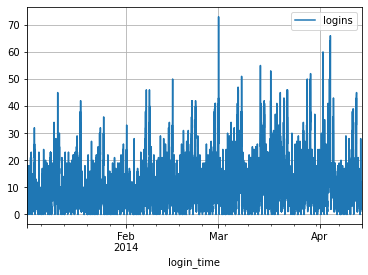

In [11]:
login_15.plot.line(grid=True)
plt.show()

The plot above shows a repeating patterns in the peaks and valleys. This might be coincidental with weeks of the month. 
We need to visualize with a little more granularity to understand the trend better. 

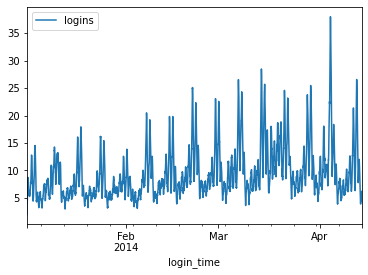

In [12]:
login_15.rolling('672min').mean().plot()

Using a weekly rolling window it definitely looks like the demand fluctuates on a weekly basis peaking on weekends. Additionally there is a rising trend to the demand. Let us try to decompose the time series data.

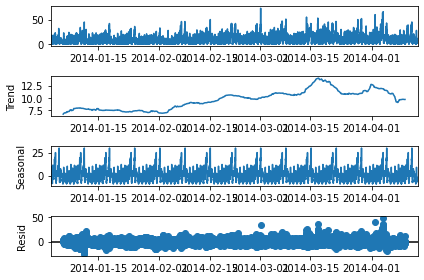

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(login_15, model='additive',period=672)

# Plot the original data, the trend, the seasonality, and the residuals 
result.plot()
plt.show()

Using a weekly period to decompose the series we observe an increasing trend in the demand until March and then it seems to slowly settle down.

In [14]:
login_15 = login_15.reset_index()

In [15]:
login_15 = time_func(login_15)

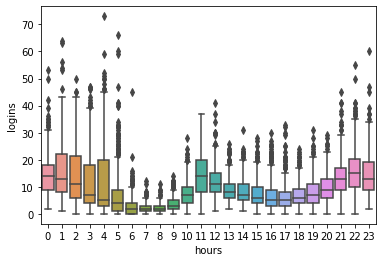

In [16]:
sns.boxplot(x="hours", y="logins", data=login_15)
plt.show()

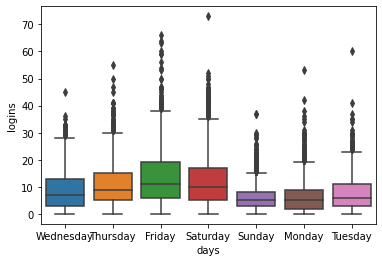

In [17]:
sns.boxplot(x="days", y="logins", data=login_15)
plt.show()

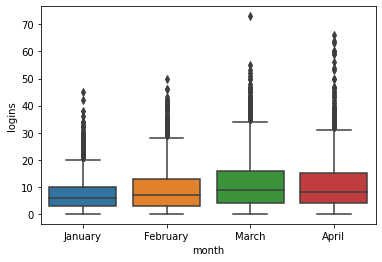

In [18]:
sns.boxplot(x="month", y="logins", data=login_15)
plt.show()

Looking at plots we can come to the following conclusions: 
* Overall there is an increasing trend in the user logins which has seemed to settle around 10 users every 15 min by end of April
* The box-plot for time of the day suggests users are mostly active during midnight. The user rate falls searly in the morning and then starts to pickup again around midday. 
* Box plot for the day of week suggests increased users on Friday and Saturday. The traffic dies on Sundays and starts to pick up again from Wednesday
* Box-plots by Month shows the most users were in March closely followed by April. Also the number of users have increased gradually from January. 

## Part 2 ‑ Experiment and metrics design

In order to test the effectiveness of this suggestioon I would devise a hypothesis test. I would first generate a random sample of population from both cities. People in this sample should be similar in terms of demographics. This would eliminate any external contributing factors. 

The assumption is that people in the sample are essentially identical. This sample will then be divided into two groups with each cities having an even representation. Group A is the group that will be offered the toll reimbursement and Group B is the group that does not have a toll reimbursement. 

Outline of our method:

   * We'll assume that toll reimbursement really doesn’t impact our user retention. This is our Null hypothesis.

   * Given this assumption, we should actually be able to get a difference in mean user retention for Group A and mean user retention for Group B. 
    
   * Since we will have a small sample we can simulate the mean user retention of the two Groups by shuffling many times, each time calculating the mean user retention of each group, and the difference between these means.

   * We can then take the mean of all these differences, and this will be called our permutation difference. This permutation difference will be great indicator of what the difference would be if our initial assumption were true and toll reimbursement doesn’t have an impact on user retention.

   Summarizing our hypothesis and confidence interval:

   * Hnull: the observed difference in the average user retention between the two groups is due to chance (and thus not due to toll reimbursement).

   * Halternative: the observed difference in the average user retention between the two groups is not due to chance (and is actually due to toll reimbursement)

   * For this analysis we will use a significance level of 0.05. 
    
In order to select the type of test we need to look at the distribution of the data. Since the user retention data in the current dataset in nt normally distributed we will chose a non-parametric test here. 
In this case, the test will be Permutation test based on the distribution of our data. 

If p-value of our analysis is less than 0.05 we will reject the null hypothesis. This means that when p-value is less than 0.05 more data are on the extremes of the distribution and is likely due to the toll reimbursement. 

With this analysis we need to keep in mind that it does not tell us at what extent does the toll reimbursement impacts user retention. As such even though we find that the Null Hypothesis is rejected we will not be able to invest on the idea without further analyzing the impact in terms of revenue and cost.

## Part 3 - Predictive Modeling

In [19]:
df = pd.read_json('ultimate_data_challenge.json')
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [20]:
df.describe(include=['O'])

,city,signup_date,last_trip_date,phone
count,50000,50000,50000,49604
unique,3,31,182,2
top,Winterfell,2014-01-18,2014-06-29,iPhone
freq,23336,2948,2036,34582


In [21]:
df.ultimate_black_user = df.ultimate_black_user.astype(object)

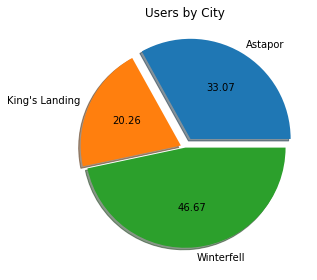

In [22]:
# fig, (ax1,ax2) = plt.subplots(ncols=1, figsize=(8, 6))
explode = (0.1, 0.05, 0)
df.groupby('city').size().plot(kind='pie',autopct='%.2f',explode=explode,shadow=True)
#df.groupby('phone').size().plot(kind='pie', textprops={'fontsize': 20},
#                                  colors=['violet', 'lime'], ax=ax2)
plt.ylabel('')
plt.title('Users by City')
# ax2.set_ylabel('User by phone', size=22)
plt.tight_layout()
plt.show()

In [23]:
df.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

Avg_rating_of_driver has the most missing values. Phone and avg_rating_by_driver are missing few hundred observations. Let's look at the distribution of the missing features. 

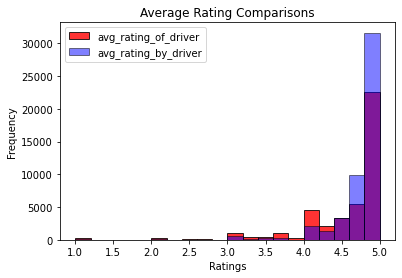

In [24]:
#sns.distplot(df['avg_rating_of_driver'],kde=False)

df['avg_rating_of_driver'].plot(kind='hist',bins=20,color='red', alpha=0.8, edgecolor='black')
df['avg_rating_by_driver'].plot(kind='hist',bins=20,color='blue', alpha=0.5, edgecolor='black')
plt.grid(False)
plt.legend(loc='upper left')
plt.margins(0.05)
plt.title('Average Rating Comparisons')
plt.xlabel('Ratings');

The distribution is skewed with median close to the maximum value. In this case it might be better to impute the missing values for this feature with mean value as it is less than the maximum. 

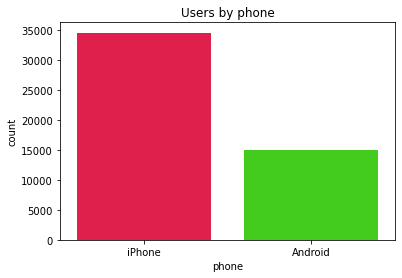

In [25]:
sns.countplot(x=df['phone'],palette='prism_r')
plt.title('Users by phone');

Clearly, more users have iPhone and imputing the missing values with iPhone seems to be a reasonable approach. Alternatively we could impute it as 'Other'. But with such small numbers it is less likely to make much difference to the outcome.

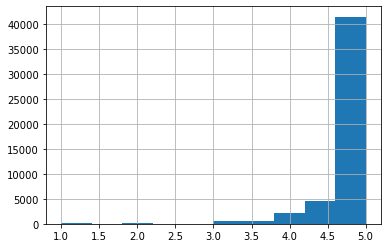

In [26]:
df['avg_rating_by_driver'].hist()
plt.show()

Again we will impute the missing values for this feature with the mean. 

In [27]:
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean())
df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean())
df['phone'] = df['phone'].replace(np.nan,'iPhone')

In [28]:
df.city.unique()

array(["King's Landing", 'Astapor', 'Winterfell'], dtype=object)

There are 3 unique cities that the users have signed up. 

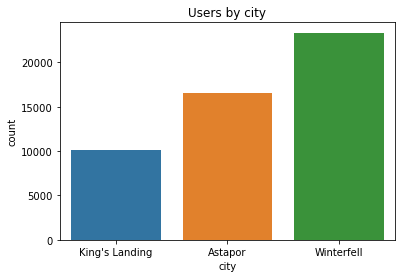

In [29]:
ax = sns.countplot(df['city'])
plt.title('Users by city');

Most of the users are from Winterfell. 

Let us change the date to datetime.

In [30]:
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

We will now calculate the difference in the last trip made by an user since the last date encountered in the datset. This will then be used to create another feature named 'user_status'. If an user's last trip is within 30 days then they are labelled as Active.

In [31]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [32]:
df['time_since_last_trip'] = (df['last_trip_date'].max() - df['last_trip_date']).dt.days.astype('float32')
df['time_since_user'] = (df['last_trip_date'].max() - df['signup_date']).dt.days.astype('float32')
df['user_status'] = np.where(df.time_since_last_trip <= 30,1, 0)

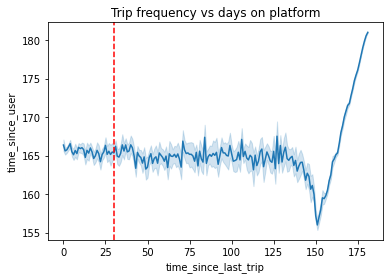

In [33]:
sns.lineplot(x='time_since_last_trip',y='time_since_user',data=df)
plt.title('Trip frequency vs days on platform')
plt.axvline(30, color = 'r', linestyle='--');

We will now one hot code all the categorical features.  

In [34]:
df['phone'] =pd.get_dummies(df['phone'])
df['ultimate_black_user'] = df['ultimate_black_user'].map({True:1,False:0})
df['city'] = df['city'].map({"King's Landing":0,'Astapor':1,'Winterfell':2})
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,time_since_last_trip,time_since_user,user_status
0,0,4,2014-01-25,4.7,1.10,2014-06-17,0,15.4,1,46.2,3.67,5.0,14.0,157.0,1
1,1,0,2014-01-29,5.0,1.00,2014-05-05,1,0.0,0,50.0,8.26,5.0,57.0,153.0,0
2,1,3,2014-01-06,4.3,1.00,2014-01-07,0,0.0,0,100.0,0.77,5.0,175.0,176.0,0
3,0,9,2014-01-10,4.6,1.14,2014-06-29,0,20.0,1,80.0,2.36,4.9,2.0,172.0,1
4,2,14,2014-01-27,4.4,1.19,2014-03-15,1,11.8,0,82.4,3.13,4.9,108.0,155.0,0


In [35]:
correlation = df.corr()

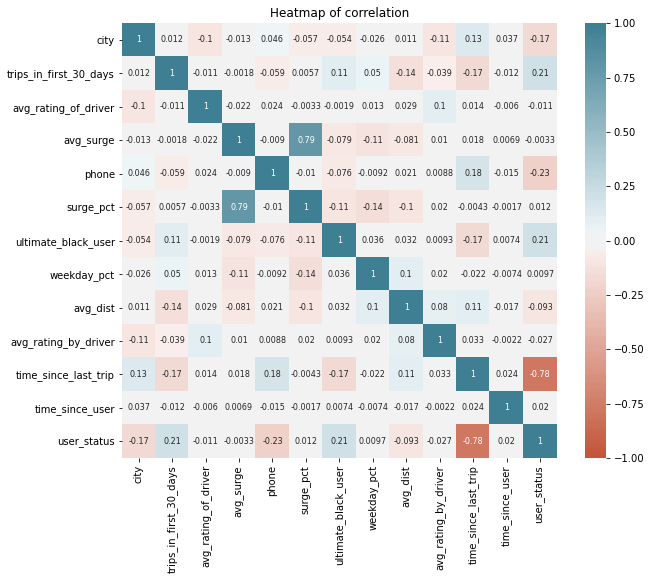

In [36]:
plt.figure(figsize=(10,8))
sns.heatmap(correlation,vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, annot=True,annot_kws={"size":8})
plt.title('Heatmap of correlation');

From the heatmap it seems that the rider retention or user status is correlated to 5 parameters. 
   * rider is a ultimate black user or not,
   * number of trips in first 30 days, 
   * the type of phone used by rider, 
   * the city they signed up in and 
   * the average distance. 

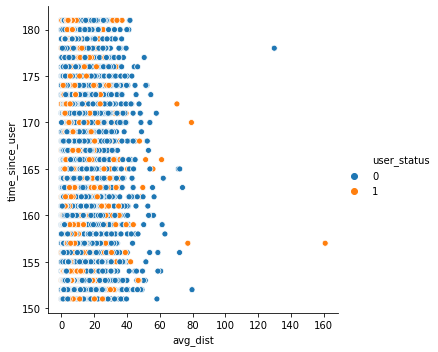

In [37]:
ax = sns.relplot(data=df,y='time_since_user',x='avg_dist',hue='user_status')

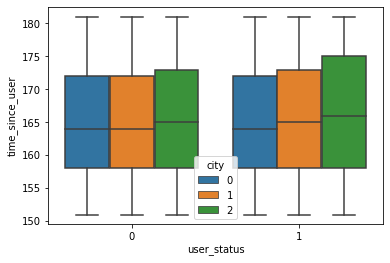

In [38]:
ax = sns.boxplot(x="user_status", y="time_since_user", hue="city", data=df)

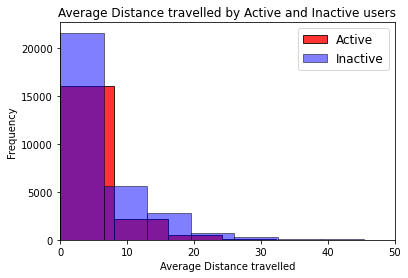

In [39]:
# sns.distplot(df[df['user_status']==1]['avg_dist'],  kde=False, label='Active')
# sns.distplot(df[df['user_status']==0]['avg_dist'],  kde=False,label='Inactive')
df[df['user_status']==1]['avg_dist'].plot(kind='hist',bins=20,color='red', alpha=0.8, edgecolor='black',label='Active')
df[df['user_status']==0]['avg_dist'].plot(kind='hist',bins=20,color='blue', alpha=0.5, edgecolor='black',label='Inactive')
plt.grid(False)
plt.legend(loc='upper left')
plt.margins(0.05)
plt.xlim(0,50)
plt.title('Average Rating Comparisons')
# Plot formatting
plt.legend(prop={'size': 12})
plt.title('Average Distance travelled by Active and Inactive users')
plt.xlabel('Average Distance travelled')
plt.show()

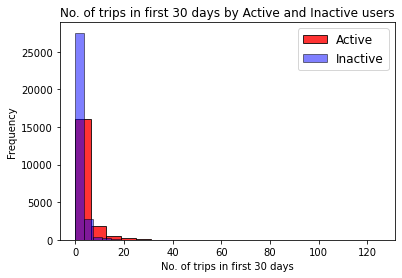

In [40]:
# sns.distplot(df[df['user_status']==1]['avg_dist'],  kde=False, label='Active')
# sns.distplot(df[df['user_status']==0]['avg_dist'],  kde=False,label='Inactive')
df[df['user_status']==1]['trips_in_first_30_days'].plot(kind='hist',bins=20,color='red', alpha=0.8, edgecolor='black',label='Active')
df[df['user_status']==0]['trips_in_first_30_days'].plot(kind='hist',bins=20,color='blue', alpha=0.5, edgecolor='black',label='Inactive')
plt.grid(False)
plt.legend(loc='upper left')
plt.margins(0.05)

plt.legend(prop={'size': 12})
plt.title('No. of trips in first 30 days by Active and Inactive users')
plt.xlabel('No. of trips in first 30 days')
plt.show()

Looks like riders who stayed Active took more trips in the first 30 days and also travelled shorter distances.

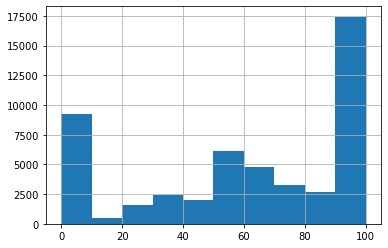

In [41]:
df['weekday_pct'].hist()
plt.show()

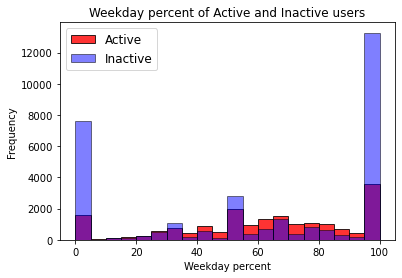

In [42]:
df[df['user_status']==1]['weekday_pct'].plot(kind='hist',bins=20,color='red', alpha=0.8, edgecolor='black',label='Active')
df[df['user_status']==0]['weekday_pct'].plot(kind='hist',bins=20,color='blue', alpha=0.5, edgecolor='black',label='Inactive')
plt.grid(False)
plt.legend(loc='upper left')
plt.margins(0.05)
# Plot formatting
plt.legend(prop={'size': 12})
plt.title('Weekday percent of Active and Inactive users')
plt.xlabel('Weekday percent')
plt.show()

Inactive users were more on the extremes of the weekday percent. 

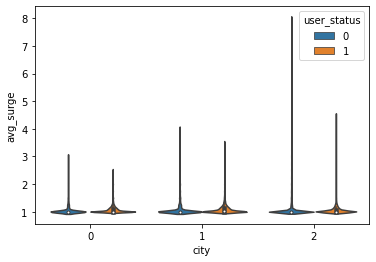

In [43]:
ax = sns.violinplot(x="city",y='avg_surge', hue="user_status", data=df)

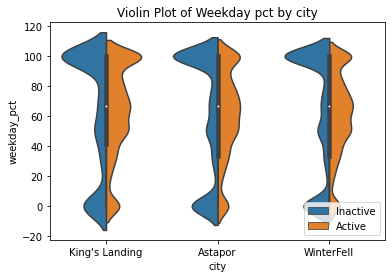

In [44]:
ax = sns.violinplot(x="city",y='weekday_pct', hue="user_status", data=df,split=True)
ax.set_xticklabels(["King's Landing",'Astapor','WinterFell'])
plt.title('Violin Plot of Weekday pct by city')

ax.legend().set_title('User Status')
new_labels = ['Inactive', 'Active']
for t, l in zip(ax.legend().texts, new_labels): t.set_text(l)
# ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1,labels=new_labels)
plt.show()

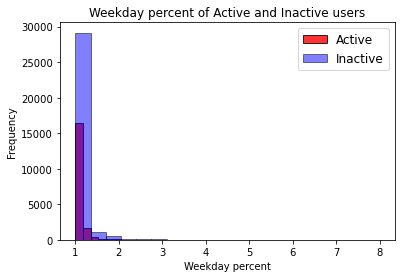

In [45]:
df[df['user_status']==1]['avg_surge'].plot(kind='hist',bins=20,color='red', alpha=0.8, edgecolor='black',label='Active')
df[df['user_status']==0]['avg_surge'].plot(kind='hist',bins=20,color='blue', alpha=0.5, edgecolor='black',label='Inactive')
plt.grid(False)
plt.legend(loc='upper left')
plt.margins(0.05)
# Plot formatting
plt.legend(prop={'size': 12})
plt.title('Weekday percent of Active and Inactive users')
plt.xlabel('Weekday percent')
plt.show()

In [46]:
fraction_retained = df[df['user_status']== 1]['user_status'].count()/df['user_status'].count()
print(fraction_retained)

0.37608


37.6% of users were retained during this time period.

In [47]:
fraction_ultimate_black_user = df[df['ultimate_black_user']== 1]['ultimate_black_user'].count()/df['ultimate_black_user'].count()
print(fraction_ultimate_black_user)

0.37708


About 37.7% of people are using Ultimate black in their first 30 days. And about this same fraction of users are active.

In [48]:
df_new = df[df['time_since_user'] >= 180]

In [49]:
fraction_retained_6_month = df_new[df_new['user_status']== 1]['user_status'].count()/df_new['user_status'].count()
print(fraction_retained_6_month)

0.39073330901130976


Looking at the 6 month retention rate we see that barely 39% of the users were retained in 6 months. This is slightly better than the overall retention.

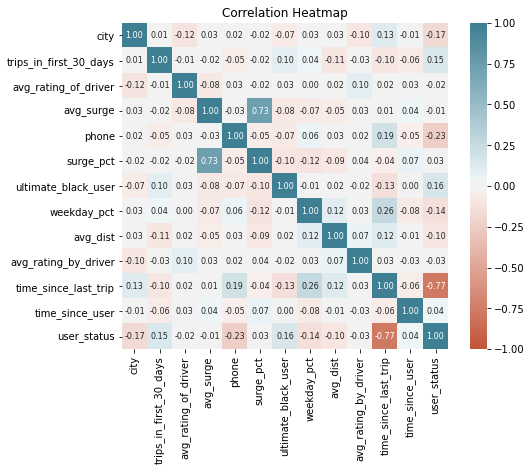

In [50]:
plt.figure(figsize=(8,6))
mask = np.triu(np.ones_like(df_new.corr(), dtype=bool))
sns.heatmap(df_new.corr(),vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,fmt='.2f', annot=True,annot_kws={"size":8})
plt.title('Correlation Heatmap');

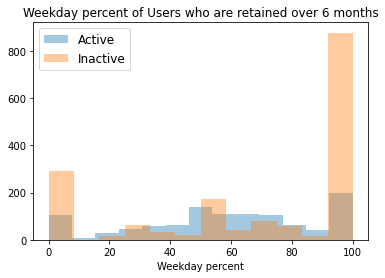

In [51]:
sns.distplot(df_new[df_new['user_status']==1]['weekday_pct'],  kde=False, label='Active')
sns.distplot(df_new[df_new['user_status']==0]['weekday_pct'],  kde=False,label='Inactive')

# Plot formatting
plt.legend(prop={'size': 12})
plt.title('Weekday percent of Users who are retained over 6 months')
plt.xlabel('Weekday percent')
#plt.ylabel('Density')
plt.show()

Users who spent between 40-60% of weekday were mostly retained. Inactive users did not have a nice distribution.

In [52]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve

from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, precision_recall_curve
import time
from sklearn import __version__ as sklearn_version


In [53]:
# define your X and y
X = df_new.drop(['user_status','signup_date','last_trip_date','time_since_last_trip','time_since_user','surge_pct'],axis=1)
y = df_new['user_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,stratify=y, random_state=42)

### Model result summay dataframe

In [54]:
columns = ['Model Name', 'accuracy','precision','recall','ROC AUC score','run time']
results = pd.DataFrame(columns=columns)

### Function for training model and metrics

In [55]:
 def metrics(model_name,y_test,y_pred):
    accuracy = accuracy_score(y_test,y_pred)
    roc_auc =roc_auc_score(y_test, y_pred)
    precision = precision_score(y_pred=y_pred, y_true=y_test,zero_division=1)
    recall = recall_score(y_pred=y_pred, y_true=y_test,zero_division=1)
    
    print(classification_report(y_test, y_pred,zero_division=1))

    cf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(cf_matrix, annot=True,fmt='3', cmap='Blues')
    plt.xlabel('Predicted user status',fontsize=12)
    plt.ylabel('True user status',fontsize=12)
    plt.title('%s Confusion Matrix' % model_name,fontsize=20)
    plt.show()

    fpr, tpr, threshold = roc_curve(y_test, y_pred)
    plt.plot([0,1], [0,1], 'k--')
    plt.plot(fpr, tpr, label=model_name)
    plt.xlabel('False Positive Rate',fontsize=12)
    plt.ylabel('True Positive Rate',fontsize=12)
    plt.title('%s ROC Curve'% model_name,fontsize=20)
    plt.legend(fontsize=12)
    plt.show()
    #pipes = pipes.append(pipe)
    return pd.DataFrame([[model_name,accuracy, precision, recall,roc_auc,t1]],columns=columns)

time to run in seconds:  0.010002374649047852
              precision    recall  f1-score   support

           0       0.61      1.00      0.76       334
           1       1.00      0.00      0.00       215

    accuracy                           0.61       549
   macro avg       0.80      0.50      0.38       549
weighted avg       0.76      0.61      0.46       549



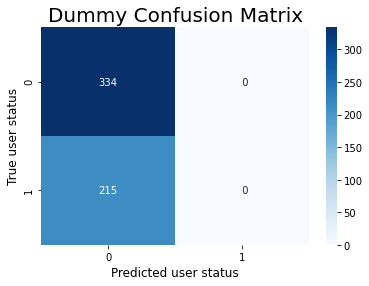

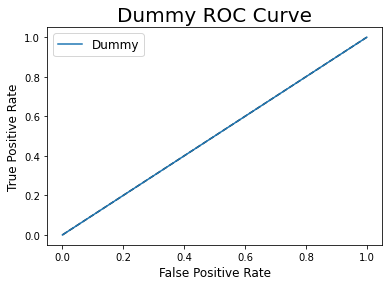

In [56]:
model_name = 'Dummy'
model = DummyClassifier(strategy='most_frequent')

pipe_dummy = make_pipeline(
       SimpleImputer(strategy='mean'), 
       StandardScaler(), 
       model)
      
##training the model
t0 = time.time()
pipe_dummy.fit(X_train,y_train)
t1 = time.time() - t0
    
#prediction with model
y_pred = pipe_dummy.predict(X_test)
print('time to run in seconds: ',format(t1)) 
results = results.append(metrics(model_name,y_test,y_pred))

time to run in seconds:  0.00876927375793457
              precision    recall  f1-score   support

           0       0.78      0.76      0.77       334
           1       0.64      0.67      0.65       215

    accuracy                           0.72       549
   macro avg       0.71      0.71      0.71       549
weighted avg       0.72      0.72      0.72       549



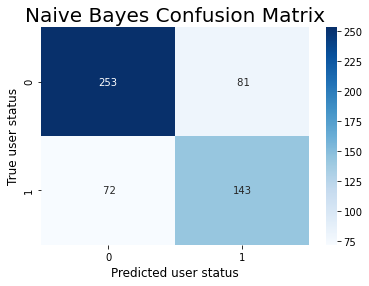

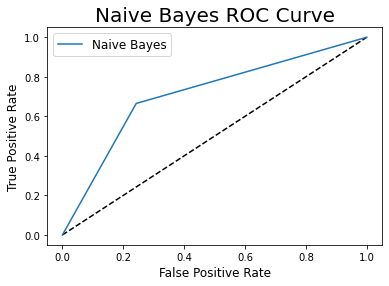

In [57]:
model_name = 'Naive Bayes'
NB = GaussianNB()
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
grid = GridSearchCV(estimator=NB, param_grid=params_NB, cv=5)
grid = grid.fit(X_train,y_train)
model = grid.best_estimator_

pipe_NB = make_pipeline(
       SimpleImputer(strategy='mean'), 
       StandardScaler(), 
       model)
      
##training the model
t0 = time.time()
pipe_NB.fit(X_train,y_train)
t1 = time.time() - t0
    
#prediction with model
y_pred = pipe_NB.predict(X_test)
print('time to run in seconds: ',format(t1))  
results = results.append(metrics(model_name,y_test,y_pred))

time to run in seconds:  0.020002126693725586
              precision    recall  f1-score   support

           0       0.71      0.87      0.78       334
           1       0.69      0.45      0.54       215

    accuracy                           0.70       549
   macro avg       0.70      0.66      0.66       549
weighted avg       0.70      0.70      0.69       549



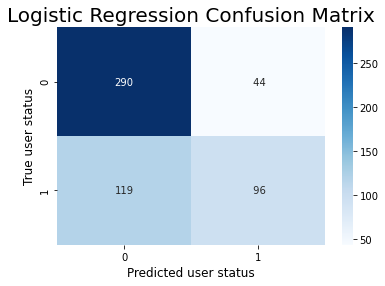

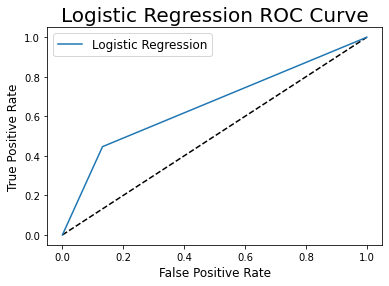

In [58]:
model_name = 'Logistic Regression'
param_grid = [{'penalty' : ['l1', 'l2'],
               'C' : np.logspace(0, 4, 10),
               'solver' : ['liblinear']}]
LR = LogisticRegression()
grid = GridSearchCV(estimator=LR, param_grid=param_grid, cv=5)
grid = grid.fit(X_train,y_train)
model = grid.best_estimator_        
        
pipe_LR = make_pipeline(
       SimpleImputer(strategy='mean'), 
       StandardScaler(), 
       model)
      
##training the model
t0 = time.time()
pipe_LR.fit(X_train,y_train)
t1 = time.time() - t0
    
#prediction with model
y_pred = pipe_LR.predict(X_test)
print('time to run in seconds: ',format(t1))  
results = results.append(metrics(model_name,y_test,y_pred))

time to run in seconds:  39.14750933647156
              precision    recall  f1-score   support

           0       0.80      0.83      0.82       334
           1       0.72      0.69      0.70       215

    accuracy                           0.77       549
   macro avg       0.76      0.76      0.76       549
weighted avg       0.77      0.77      0.77       549



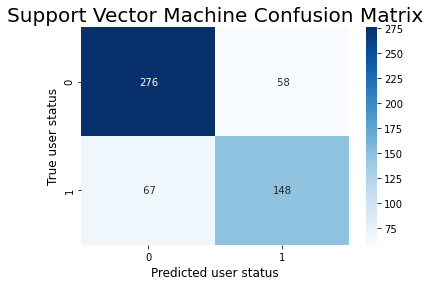

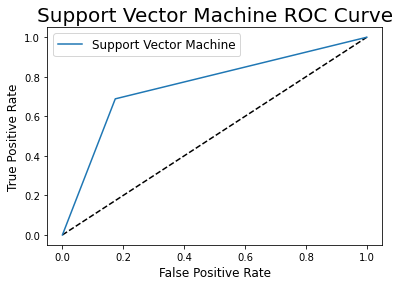

In [59]:
model_name = 'Support Vector Machine'
svc = SVC()
param_grid = {'C': [1, 10, 100],  
              'gamma': [1, 0.1, 0.01], 
              'kernel': ['sigmoid','rbf']}  
model = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5)
        
pipe_SVC = make_pipeline(
       SimpleImputer(strategy='mean'), 
       StandardScaler(), 
       model)
      
##training the model
t0 = time.time()
pipe_SVC.fit(X_train,y_train)
t1 = time.time() - t0
    
#prediction with model
y_pred = pipe_SVC.predict(X_test)
print('time to run in seconds: ',format(t1))  
results = results.append(metrics(model_name,y_test,y_pred))

time to run in seconds:  0.019996166229248047
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       334
           1       0.73      0.67      0.70       215

    accuracy                           0.77       549
   macro avg       0.76      0.75      0.76       549
weighted avg       0.77      0.77      0.77       549



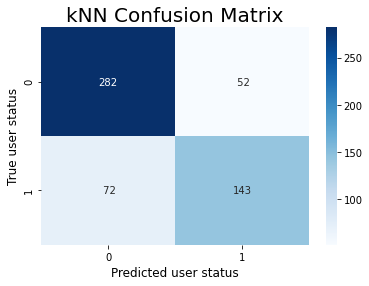

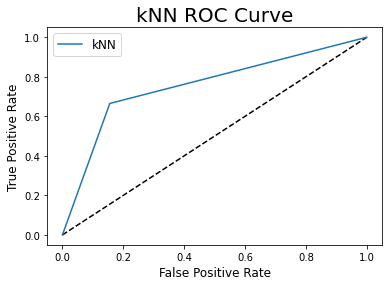

In [60]:
model_name = 'kNN'
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [3, 5, 7, 9, 11],
              'weights': ['uniform', 'distance']
             }  
grid = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5)
grid = grid.fit(X_train,y_train)
model = grid.best_estimator_

pipe_kNN = make_pipeline(
       SimpleImputer(strategy='mean'), 
       StandardScaler(), 
       model)
      
##training the model
t0 = time.time()
pipe_kNN.fit(X_train,y_train)
t1 = time.time() - t0
    
#prediction with model
y_pred = pipe_kNN.predict(X_test)
print('time to run in seconds: ',format(t1))  
results = results.append(metrics(model_name,y_test,y_pred))

time to run in seconds:  1.9580049514770508
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       334
           1       0.76      0.67      0.71       215

    accuracy                           0.79       549
   macro avg       0.78      0.77      0.77       549
weighted avg       0.78      0.79      0.78       549



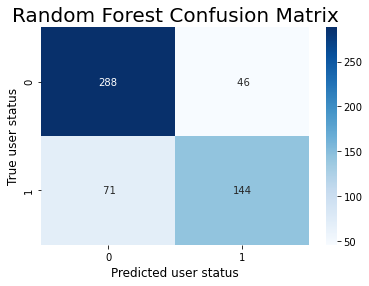

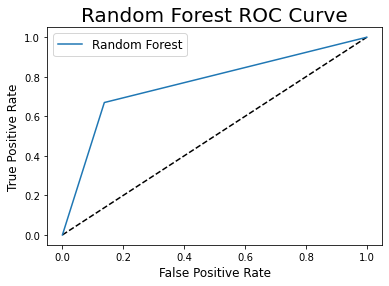

In [61]:
model_name = 'Random Forest'
rfc=RandomForestClassifier(random_state=42)
param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth' : [5,10,15,20],
              'criterion' :['gini', 'entropy']}
grid = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5) 
grid = grid.fit(X_train,y_train)
model = grid.best_estimator_
        
pipe_rfc = make_pipeline(
       SimpleImputer(strategy='mean'), 
       StandardScaler(), 
       model)
      
##training the model
t0 = time.time()
pipe_rfc.fit(X_train,y_train)
t1 = time.time() - t0
    
#prediction with model
y_pred = pipe_rfc.predict(X_test)
print('time to run in seconds: ',format(t1))  
results = results.append(metrics(model_name,y_test,y_pred))

In [67]:
results

,Model Name,accuracy,precision,recall,ROC AUC score,run time
0,Dummy,0.608379,1.000000,0.000000,0.500000,0.010002
0,Naive Bayes,0.721311,0.638393,0.665116,0.711301,0.008769
0,Logistic Regression,0.703097,0.685714,0.446512,0.657388,0.020002
0,Support Vector Machine,0.772313,0.718447,0.688372,0.757360,39.147509
0,kNN,0.774135,0.733333,0.665116,0.754714,0.019996
0,Random Forest,0.786885,0.757895,0.669767,0.766021,1.958005


### Model Performances

In [62]:
pipe_rfc.named_steps['randomforestclassifier']

RandomForestClassifier(criterion='entropy', max_depth=10, random_state=42)

Among all the models Support Vector Machine has the best accuracy. IT has marginally higher ROC-AUC score and a lower precision. It also took longer to run. Since SVM are typically not great with large datasets and struggle with data that does not have good separation I will not recommend this model. With more data the model might perform poorly. Random Forest has the best precision and had comparable run time. In this case of user retention since our focus is also not on marginal opportunities, a model with higher precision will be better. 

### Feature Importance of best model

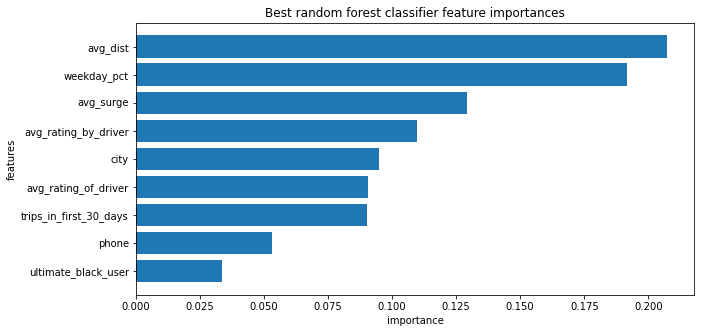

In [63]:
plt.subplots(figsize=(10, 5))
imps = pipe_rfc.named_steps['randomforestclassifier'].feature_importances_
#rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
sorted_idx = imps.argsort()
plt.barh(X_train.columns[sorted_idx], imps[sorted_idx])
plt.ylabel('features')
plt.xlabel('importance')
plt.title('Best random forest classifier feature importances');

Let's take a closer look at the top features.

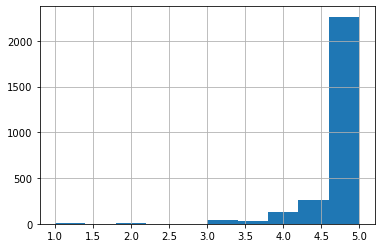

In [64]:
df_new['avg_rating_by_driver'].hist()
plt.show()

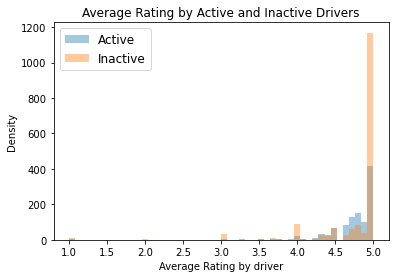

In [65]:
sns.distplot(df_new[df_new['user_status']==1]['avg_rating_by_driver'],  kde=False, label='Active')
sns.distplot(df_new[df_new['user_status']==0]['avg_rating_by_driver'],  kde=False,label='Inactive')

# Plot formatting
plt.legend(prop={'size': 12})
plt.title('Average Rating by Active and Inactive Drivers')
plt.xlabel('Average Rating by driver')
plt.ylabel('Density')
plt.show()

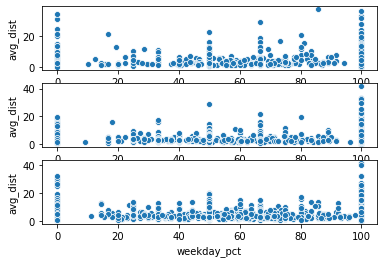

In [66]:
fig, (ax1, ax2, ax3) = plt.subplots(3)
sns.scatterplot(data=df_new[df_new['city'] == 0],x='weekday_pct',y='avg_dist',ax=ax1)
sns.scatterplot(data=df_new[df_new['city'] == 1],x='weekday_pct',y='avg_dist',ax=ax2)
sns.scatterplot(data=df_new[df_new['city'] == 2],x='weekday_pct',y='avg_dist',ax=ax3)

### Strategic Retention Plan

The stronger indicators of users being active include:
   * Weekday percent: Drivers who had more trips on weekdays were retained. A plot of average distance travelled and weekday percent by city shows that city "WniterFell" had most rides on weekdays followed by King's Landing. Perhaps the proposal to reimburse tolls between cities might help user retention from the other two cities. Also, a study on the demographics of the city population might help understand where there is more portential for riders and devise plans accordingly.      
   * Average Rating by Driver: Drivers who rated higher were mostly active. Hence, efforts should be made to gather information on what contributes to a higher rating and finding ways to improve those in order to retain more drivers.
   * Phone: People who used the app on iPhone tend to be retained more than those on Android. The team can conduct a study to understand if there is a significant difference between apps on each of the platforms.
   * trips_in_first_30_days: Users who had more rides in the first 30 days tend to be retained.
  
   A strategic "Retention Plan" should be drawn for each features. In addition to the suggested steps for each feature listed above, further analysis on platforms of app, user demographics across cities, information about fare per distance unit will be necessary to draw a solid plan. Additionally, doing a survey on driver's to gain insight behind their ratings needs to be included in the plan.
